In [4]:
import scanpy as sc
import snapatac2 as snap
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import SEACells

In [6]:
expr = sc.read_h5ad("/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/data/Joint_finalist/RNA_data.h5ad")
expr

AnnData object with n_obs × n_vars = 64775 × 19889
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treatment', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'SCT_snn_res.0.4', 'seurat_clusters', 'SCT_snn_res.0.3', 'RNA_anno', 'barcodes'
    var: 'gene_ids'
    uns: 'RNA_anno_colors'
    obsm: 'X_pca', 'X_umap'

In [4]:
raw_ad = sc.AnnData(expr.X)
raw_ad.obs_names, raw_ad.var_names = expr.obs_names, expr.var_names
expr.raw = raw_ad

# process data with SCANPY
# note that we don't scale the data matrix before PCA. this is how
# they do it in the SEACells tutorial so we do it that way here.
sc.pp.normalize_per_cell(expr)
sc.pp.log1p(expr)
sc.pp.highly_variable_genes(expr, n_top_genes=2000)

/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


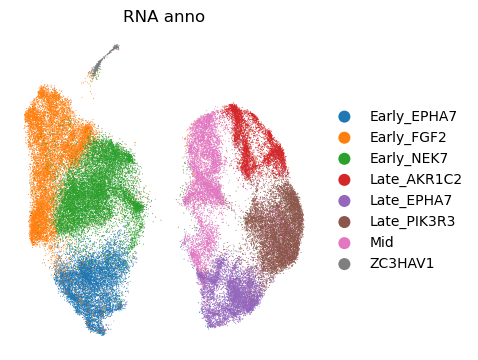

In [5]:
sc.pl.scatter(expr, basis='umap', color='RNA_anno', frameon=False)

In [12]:
adata = expr[expr.obs["RNA_anno"] != "ZC3HAV1"]
adata

View of AnnData object with n_obs × n_vars = 64181 × 19889
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treatment', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'SCT_snn_res.0.4', 'seurat_clusters', 'SCT_snn_res.0.3', 'RNA_anno', 'barcodes'
    var: 'gene_ids'
    uns: 'RNA_anno_colors'
    obsm: 'X_pca', 'X_umap'

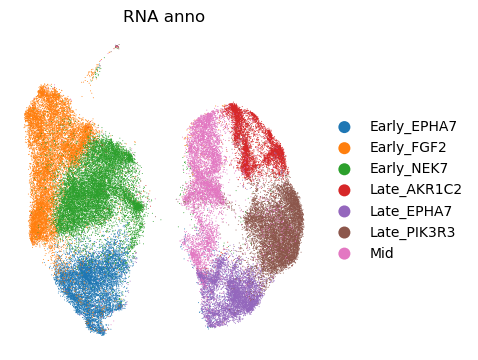

In [7]:
sc.pl.scatter(adata, basis='umap', color='RNA_anno', frameon=False)

In [8]:
## User defined parameters

## Core parameters 
n_SEACells = int(np.floor(adata.obs.shape[0] / 300)) #1000 or 150
print(n_SEACells, "SEACells created")
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 15 # Number of eigenvalues to consider when initializing metacells

213 SEACells created


In [9]:
model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5, 
                  use_sparse = True)

Welcome to SEACells!


In [10]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/64181 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/64181 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/64181 [00:00<?, ?it/s]

Constructing CSR matrix...


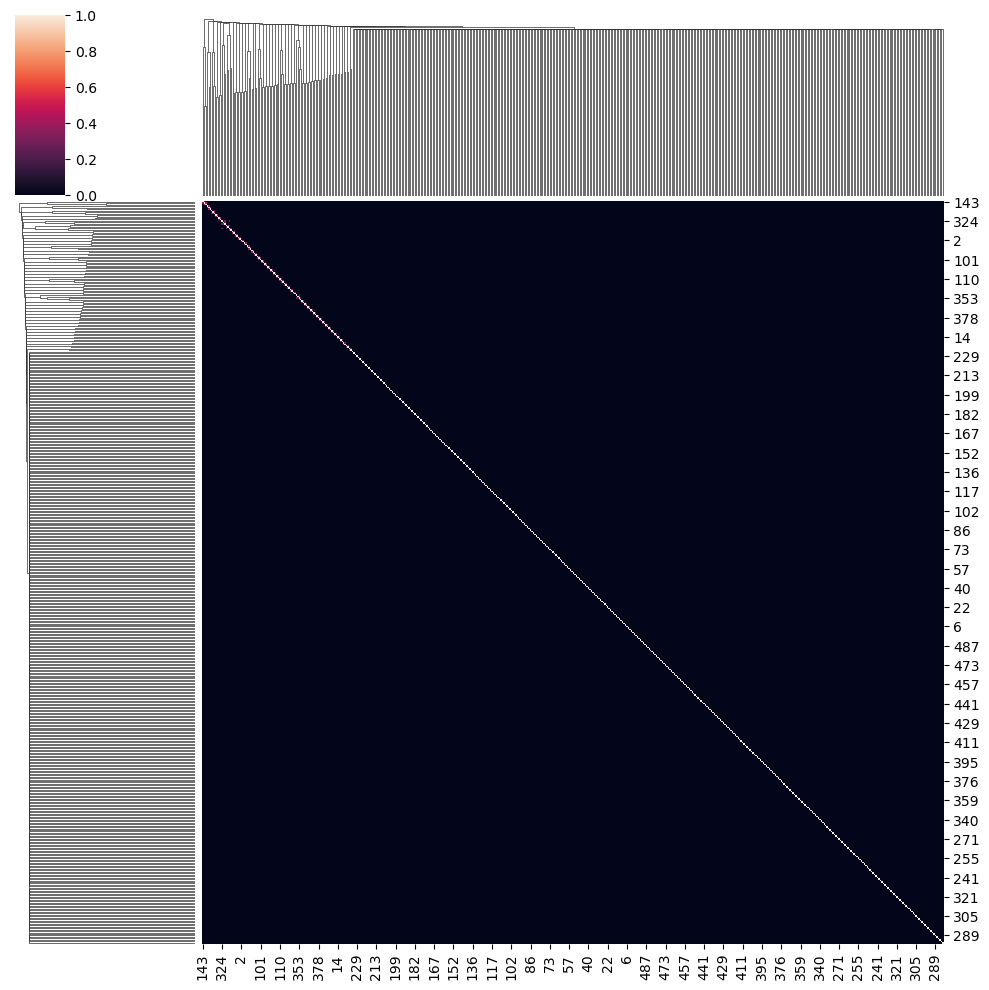

In [11]:
sns.clustermap(M.toarray()[:500,:500])

In [12]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 204 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 19/19 [00:06<00:00,  3.11it/s]

Selecting 9 cells from greedy initialization.


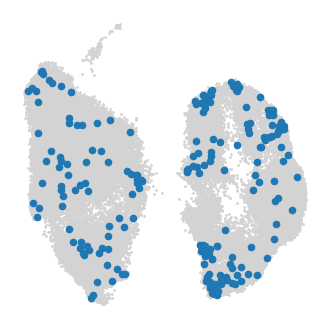

In [13]:
SEACells.plot.plot_initialization(adata, model)

In [14]:
import pickle
dir = "/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/analysis/RNA/SEACells/model300_untrained.pkl" #model 150 or 1000
with open(dir, 'wb') as f:
    pickle.dump(model, f)

In [ ]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00477
Starting iteration 1.
Completed iteration 1.
Starting iteration 20.
Completed iteration 20.


In [ ]:
# Check for convergence 
model.plot_convergence()

In [16]:
model.get_hard_assignments().head()

,SEACell
index,
01_A1:AN:01,SEACell-30
01_A1:B1:03,SEACell-19
01_A1:BE:04,SEACell-12
01_A1:C1:02,SEACell-17
01_A1:DI:02,SEACell-44


In [8]:
import pickle
dir = "/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/analysis/RNA/SEACells/model300_trained.pkl" #model 150 or 1000

with open(dir, 'rb') as f:
    # Load the pickled object from the file
    model = pickle.load(f)

In [11]:
hard_assignment = model.get_hard_assignments()
hard_assignment.index.name = None
hard_assignment.head()

,SEACell
01_A1:AN:01,SEACell-182
01_A1:B1:03,SEACell-195
01_A1:BE:04,SEACell-43
01_A1:C1:02,SEACell-182
01_A1:DI:02,SEACell-74


In [13]:
adata.obs = adata.obs.join(hard_assignment)

/gpfs/commons/groups/zhu_lab/zcao/tools/SEACells/SEACells/plot.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mcs = umap.groupby("SEACell").mean().reset_index()
/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/seaborn/

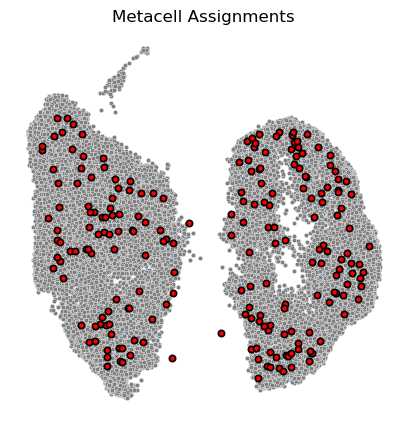

In [15]:
SEACells.plot.plot_2D(adata, key='X_umap', colour_metacells=False)

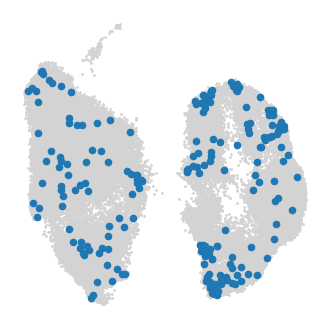

In [16]:
SEACells.plot.plot_initialization(adata, model)

/gpfs/commons/groups/zhu_lab/zcao/tools/SEACells/SEACells/plot.py:130: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby("SEACell").count().iloc[:, 0], bins=bins)
/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv

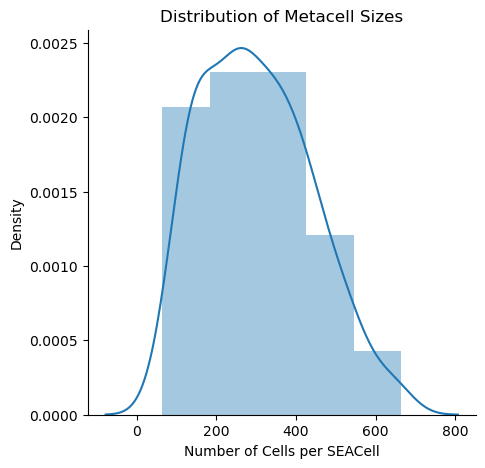

,size
SEACell,
SEACell-0,348
SEACell-1,120
SEACell-10,208
SEACell-100,240
SEACell-101,164
...,...
SEACell-95,274
SEACell-96,76
SEACell-97,320


In [17]:
SEACells.plot.plot_SEACell_sizes(adata, bins=5)

In [21]:
adata.obs["SEACell"].head()

index
01_A1:AN:01    SEACell-240
01_A1:B1:03    SEACell-109
01_A1:BE:04    SEACell-243
01_A1:C1:02    SEACell-317
01_A1:DI:02    SEACell-147
Name: SEACell, dtype: object

/scratch/ipykernel_49580/2761727437.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)


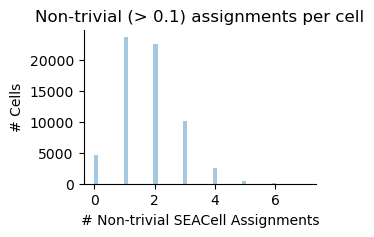

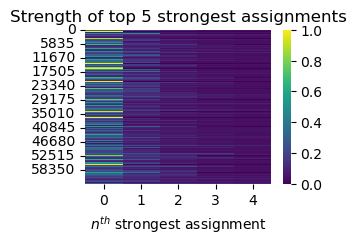

In [22]:
plt.figure(figsize=(3,2))
sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)
plt.title(f'Non-trivial (> 0.1) assignments per cell')
plt.xlabel('# Non-trivial SEACell Assignments')
plt.ylabel('# Cells')
plt.show()

plt.figure(figsize=(3,2))
b = np.partition(model.A_.T, -5)    
sns.heatmap(np.sort(b[:,-5:])[:, ::-1], cmap='viridis', vmin=0)
plt.title('Strength of top 5 strongest assignments')
plt.xlabel('$n^{th}$ strongest assignment')
plt.show()

In [23]:
SEACell_ad = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', celltype_label = "RNA_anno", summarize_layer='raw')
SEACell_ad

100%|██████████| 427/427 [00:03<00:00, 134.91it/s]


AnnData object with n_obs × n_vars = 427 × 19889
    obs: 'RNA_anno', 'RNA_anno_purity'
    layers: 'raw'

In [24]:
SEACell_ad.obs["RNA_anno_purity"].describe()

count    427.000000
mean       0.893624
std        0.123772
min        0.331288
25%        0.860941
50%        0.936842
75%        0.977525
max        1.000000
Name: RNA_anno_purity, dtype: float64

In [25]:
SEACell_ad.layers["raw"] = SEACell_ad.X.copy()
sc.experimental.pp.recipe_pearson_residuals(SEACell_ad)

In [26]:
SEACell_ad

AnnData object with n_obs × n_vars = 427 × 19889
    obs: 'RNA_anno', 'RNA_anno_purity'
    var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'hvg', 'pca', 'pearson_residuals_normalization'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [27]:
sc.pp.neighbors(SEACell_ad, n_neighbors=10, n_pcs=40)

... storing 'RNA_anno' as categorical


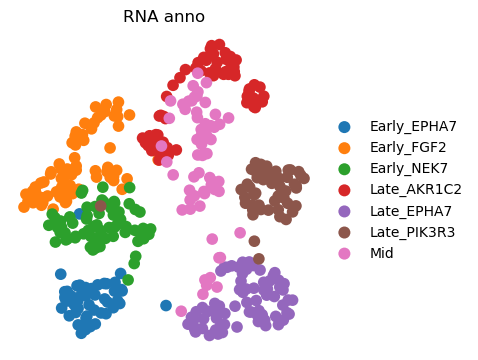

In [28]:
sc.tl.umap(SEACell_ad)
sc.pl.scatter(SEACell_ad, basis='umap', color='RNA_anno', frameon=False)

In [29]:
SEACell_ad.write("/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/analysis/RNA/SEACells/SEACells_RNA.h5ad")

In [30]:
model

/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gpfs/commons/home/zcao/.conda/envs/scpy/lib

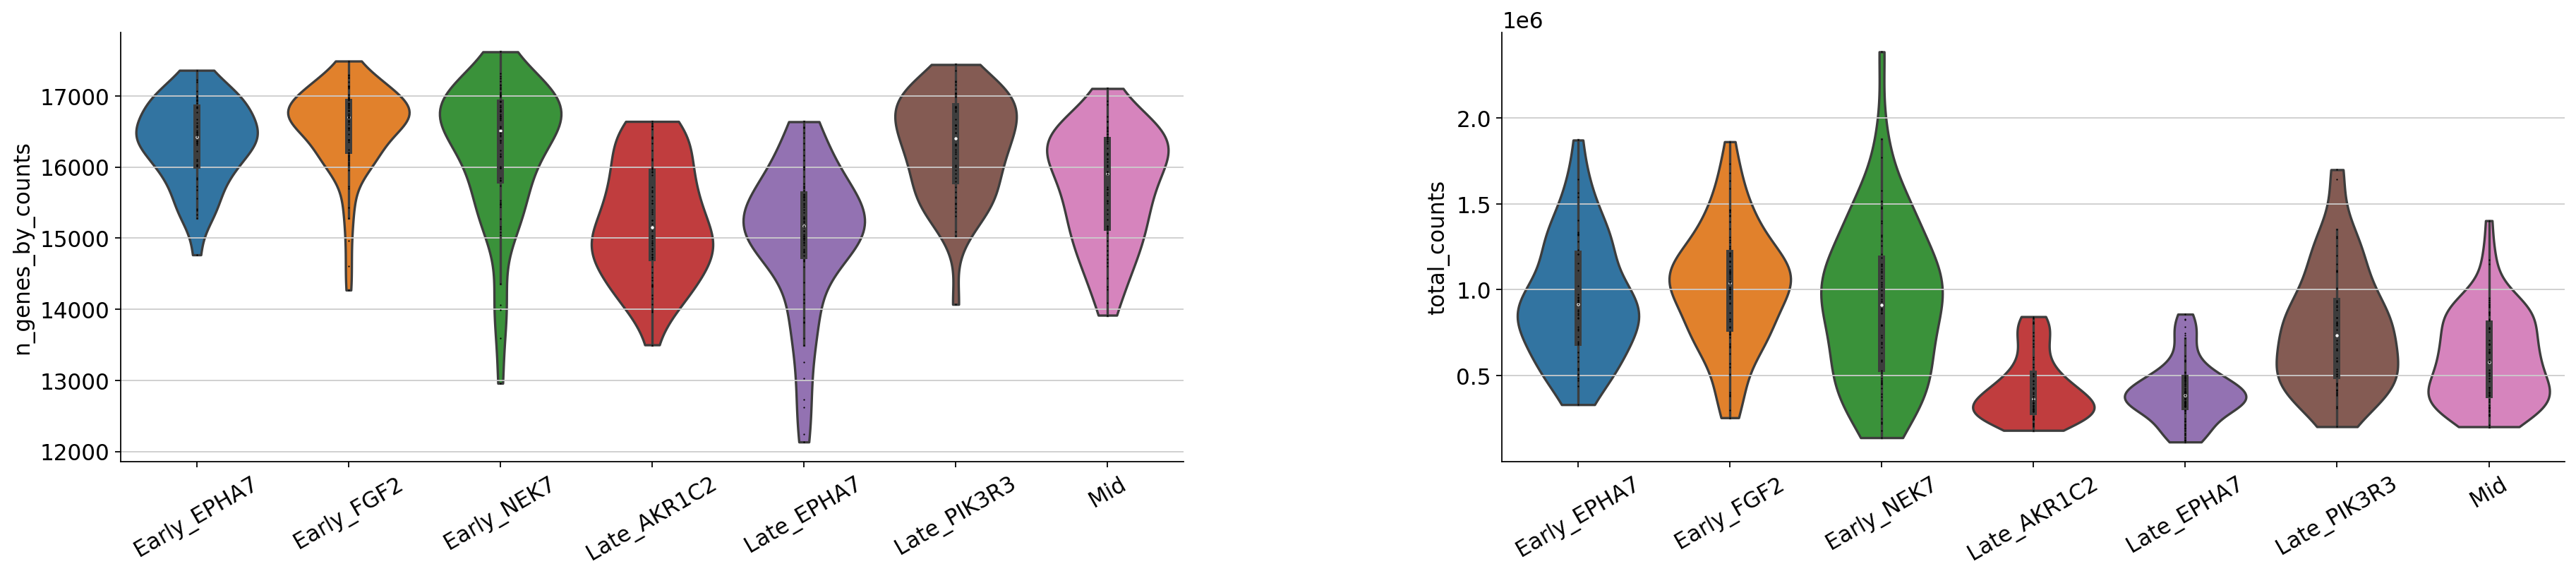

In [31]:
sc.set_figure_params(figsize=(10,5))
sc.pp.calculate_qc_metrics(SEACell_ad, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(SEACell_ad, ['n_genes_by_counts', 'total_counts'],
             jitter=0, multi_panel=True, inner = "box", groupby = "RNA_anno", rotation = 30)

/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gpfs/commons/home/zcao/.conda/envs/scpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gpfs/commons/home/zcao/.conda/envs/scpy/lib

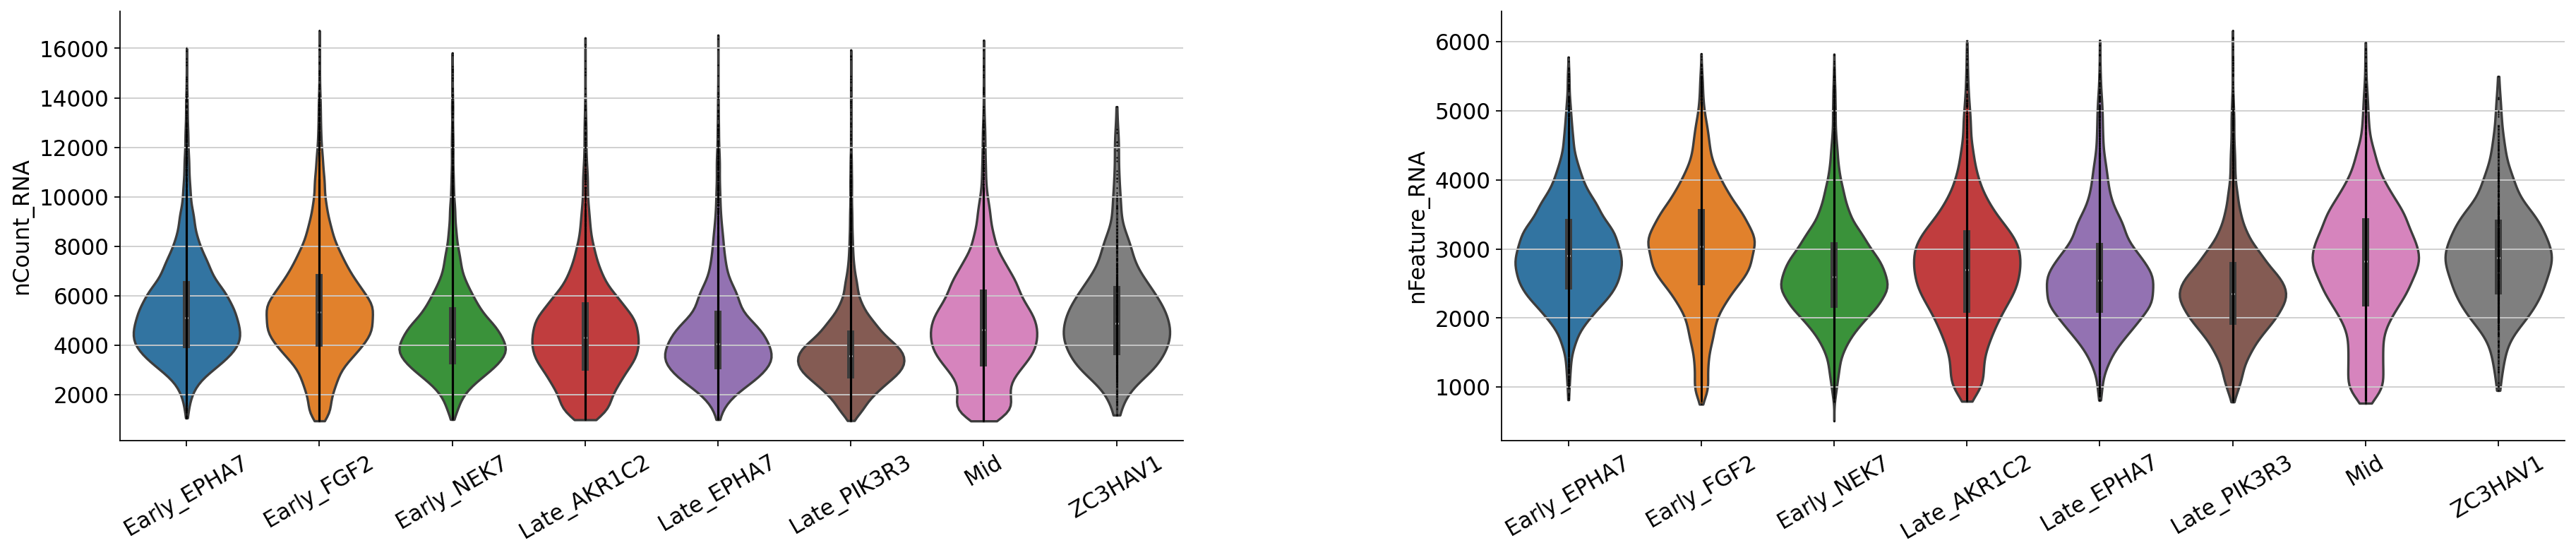

In [32]:
sc.pl.violin(expr, ['nCount_RNA', 'nFeature_RNA'],
             jitter=0, multi_panel=True, inner = "box", groupby = "RNA_anno", rotation = 30)

In [33]:
damage_ad = snap.read("/gpfs/commons/groups/zhu_lab/zcao/Paired_damage/data/SnapATAC2_whitelist/peak_matrix_obj.h5ad", backed = None)
damage_ad

AnnData object with n_obs × n_vars = 64794 × 1733268
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treatment', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'SCT_snn_res.0.4', 'seurat_clusters', 'SCT_snn_res.0.3', 'RNA_anno', 'barcodes', 'n_reads_by_Damage_Peak', 'log1p_n_reads_by_Damage_Peak', 'total_Damage_Peak', 'log1p_total_Damage_Peak', 'pct_Damage_Peak_in_top_50_reads', 'pct_Damage_Peak_in_top_100_reads', 'pct_Damage_Peak_in_top_200_reads', 'pct_Damage_Peak_in_top_500_reads'
    var: 'n_cells_by_Damage_Peak', 'mean_Damage_Peak', 'log1p_mean_Damage_Peak', 'pct_dropout_by_Damage_Peak', 'total_Damage_Peak', 'log1p_total_Damage_Peak'
    uns: 'RNA_anno_colors'

In [34]:
damage_ad_test = damage_ad[damage_ad.obs["RNA_anno"] == "ZC3HAV1"]
expr_test = expr[expr.obs["RNA_anno"] == "ZC3HAV1"]
damage_ad_test.obs

,orig.ident,nCount_RNA,nFeature_RNA,Treatment,nCount_SCT,nFeature_SCT,S.Score,G2M.Score,Phase,SCT_snn_res.0.4,...,RNA_anno,barcodes,n_reads_by_Damage_Peak,log1p_n_reads_by_Damage_Peak,total_Damage_Peak,log1p_total_Damage_Peak,pct_Damage_Peak_in_top_50_reads,pct_Damage_Peak_in_top_100_reads,pct_Damage_Peak_in_top_200_reads,pct_Damage_Peak_in_top_500_reads
01_BI:CI:02,1,8268,3747,Ctrl,5385,3361,-0.056232,0.137894,G2M,10,...,ZC3HAV1,01_AA:F5:01,2025,7.613819,3047,8.022241,6.892025,11.913357,21.759107,42.008533
01_CA:LA:01,1,1180,951,48hr,3123,1378,-0.095821,0.073513,G2M,10,...,ZC3HAV1,01_AF:DB:11,498,6.212606,718,6.577861,22.841226,36.768802,58.495822,100.000000
01_E2:JA:02,1,4276,2625,0hr,4264,2611,0.094691,0.129182,G2M,10,...,ZC3HAV1,01_AN:KB:03,2567,7.850883,3818,8.247744,5.657412,10.031430,17.888947,35.175485
01_EA:LQ:01,1,4344,2573,48hr,4332,2560,0.017306,-0.082983,S,10,...,ZC3HAV1,01_AQ:EQ:11,1428,7.264730,2103,7.651596,8.796957,15.929624,27.722301,55.872563
01_FB:A6:01,1,9549,4361,Ctrl,5364,3540,0.040459,-0.040793,S,10,...,ZC3HAV1,01_AV:KR:02,996,6.904751,1479,7.299797,11.967546,22.109533,36.511156,66.463827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16_EQ:HN:12,16,4275,2611,Ctrl,4272,2604,-0.009383,-0.004508,G1,10,...,ZC3HAV1,16_KV:AA:02,973,6.881411,1417,7.257003,12.420607,22.865208,36.979534,66.619619
16_GJ:I2:11,16,7514,3800,2hr,5302,3620,-0.040937,-0.004688,G1,10,...,ZC3HAV1,16_L5:GJ:06,1095,6.999422,1589,7.371489,11.831340,21.271240,33.983638,62.555066
16_HJ:IJ:11,16,8819,4109,0hr,5395,3533,-0.232099,-0.024667,G1,10,...,ZC3HAV1,16_LB:F2:03,1097,7.001246,1614,7.387090,11.648079,20.941760,34.138786,63.011152
16_J1:GJ:12,16,5427,3154,2hr,5126,3133,-0.058501,0.301633,G2M,10,...,ZC3HAV1,16_LJ:E1:05,941,6.848005,1359,7.215240,12.656365,22.663723,37.380427,67.549669


In [35]:
expr_test.obs

,orig.ident,nCount_RNA,nFeature_RNA,Treatment,nCount_SCT,nFeature_SCT,S.Score,G2M.Score,Phase,SCT_snn_res.0.4,seurat_clusters,SCT_snn_res.0.3,RNA_anno,barcodes,n_counts
01_AA:F5:01,1,8268,3747,Ctrl,5385,3361,-0.056232,0.137894,G2M,10,8,8,ZC3HAV1,01_AA:F5:01,8271.0
01_AF:DB:11,1,1180,951,48hr,3123,1378,-0.095821,0.073513,G2M,10,8,8,ZC3HAV1,01_AF:DB:11,1180.0
01_AN:KB:03,1,4276,2625,0hr,4264,2611,0.094691,0.129182,G2M,10,8,8,ZC3HAV1,01_AN:KB:03,4293.0
01_AQ:EQ:11,1,4344,2573,48hr,4332,2560,0.017306,-0.082983,S,10,8,8,ZC3HAV1,01_AQ:EQ:11,4363.0
01_AV:KR:02,1,9549,4361,Ctrl,5364,3540,0.040459,-0.040793,S,10,8,8,ZC3HAV1,01_AV:KR:02,9600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16_KV:AA:02,16,4275,2611,Ctrl,4272,2604,-0.009383,-0.004508,G1,10,8,8,ZC3HAV1,16_KV:AA:02,4283.0
16_L5:GJ:06,16,7514,3800,2hr,5302,3620,-0.040937,-0.004688,G1,10,8,8,ZC3HAV1,16_L5:GJ:06,7516.0
16_LB:F2:03,16,8819,4109,0hr,5395,3533,-0.232099,-0.024667,G1,10,8,8,ZC3HAV1,16_LB:F2:03,8824.0
16_LJ:E1:05,16,5427,3154,2hr,5126,3133,-0.058501,0.301633,G2M,10,8,8,ZC3HAV1,16_LJ:E1:05,5431.0


In [36]:
sum(expr_test.obs.index.isin(damage_ad_test.obs.index))

4

In [37]:
damage_ad = damage_ad[damage_ad.obs["RNA_anno"] != "ZC3HAV1"]
damage_ad

View of AnnData object with n_obs × n_vars = 64200 × 1733268
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treatment', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'SCT_snn_res.0.4', 'seurat_clusters', 'SCT_snn_res.0.3', 'RNA_anno', 'barcodes', 'n_reads_by_Damage_Peak', 'log1p_n_reads_by_Damage_Peak', 'total_Damage_Peak', 'log1p_total_Damage_Peak', 'pct_Damage_Peak_in_top_50_reads', 'pct_Damage_Peak_in_top_100_reads', 'pct_Damage_Peak_in_top_200_reads', 'pct_Damage_Peak_in_top_500_reads'
    var: 'n_cells_by_Damage_Peak', 'mean_Damage_Peak', 'log1p_mean_Damage_Peak', 'pct_dropout_by_Damage_Peak', 'total_Damage_Peak', 'log1p_total_Damage_Peak'
    uns: 'RNA_anno_colors'

In [38]:
adata

AnnData object with n_obs × n_vars = 64181 × 19889
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treatment', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'SCT_snn_res.0.4', 'seurat_clusters', 'SCT_snn_res.0.3', 'RNA_anno', 'barcodes', 'n_counts', 'SEACell'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'RNA_anno_colors', 'log1p', 'hvg', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [39]:
sum(adata.obs.index.isin(damage_ad.obs.index))

63591

In [40]:
damage_ad.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,Treatment,nCount_SCT,nFeature_SCT,S.Score,G2M.Score,Phase,SCT_snn_res.0.4,...,RNA_anno,barcodes,n_reads_by_Damage_Peak,log1p_n_reads_by_Damage_Peak,total_Damage_Peak,log1p_total_Damage_Peak,pct_Damage_Peak_in_top_50_reads,pct_Damage_Peak_in_top_100_reads,pct_Damage_Peak_in_top_200_reads,pct_Damage_Peak_in_top_500_reads
01_A1:AN:01,1,7497,3892,Ctrl,5325,3700,-0.062921,-0.012619,G1,1,...,Early_FGF2,01_A1:AN:01,460,6.133398,701,6.553933,23.537803,37.803138,62.910128,100.000000
01_A1:C1:02,1,3175,2060,0hr,3725,2050,-0.056657,-0.093246,G1,1,...,Early_NEK7,01_A1:B1:03,2616,7.869784,3906,8.270525,5.632360,9.907834,17.588326,34.767025
01_A1:DI:02,1,2727,1840,0hr,3651,1834,-0.055581,-0.053016,G1,4,...,Early_EPHA7,01_A1:BE:04,3407,8.133881,5107,8.538563,4.425299,7.989035,13.863325,28.705698
01_A1:HR:02,1,4796,2859,Ctrl,4769,2851,0.058400,0.093314,G2M,1,...,Early_FGF2,01_A1:C1:02,2308,7.744570,3414,8.135933,5.946104,10.339777,19.127124,37.170475
01_A1:JE:02,1,4486,2678,Ctrl,4471,2663,-0.145539,0.040136,G2M,3,...,Early_FGF2,01_A1:DI:02,3745,8.228444,5634,8.636752,3.975861,7.525737,12.939297,27.085552


In [41]:
SEACell_assignment = model.get_hard_assignments()
SEACell_assignment

,SEACell
index,
01_A1:AN:01,SEACell-240
01_A1:B1:03,SEACell-109
01_A1:BE:04,SEACell-243
01_A1:C1:02,SEACell-317
01_A1:DI:02,SEACell-147
...,...
16_LV:IM:01,SEACell-154
16_LV:JA:12,SEACell-387
16_LV:JN:04,SEACell-163


In [42]:
SEACell_assignment.index.name = None
SEACell_assignment

,SEACell
01_A1:AN:01,SEACell-240
01_A1:B1:03,SEACell-109
01_A1:BE:04,SEACell-243
01_A1:C1:02,SEACell-317
01_A1:DI:02,SEACell-147
...,...
16_LV:IM:01,SEACell-154
16_LV:JA:12,SEACell-387
16_LV:JN:04,SEACell-163
16_LV:KU:10,SEACell-327


In [43]:
sum(damage_ad.obs.index.isin(expr.obs.index))

64181